<a href="https://colab.research.google.com/github/HongyuJiang/hairBall/blob/master/Cells_relations_in_urban.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function

import pandas as pd


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_to_file = '/content/drive/My Drive/LDA Recommendation/selected.csv'

f = open(path_to_file, encoding='gb18030', errors='ignore')

cells_ID = dict()

cells_ID_reverse = dict()
persons_sequence = dict()


In [ ]:
# 工作日工作时间访问次数，工作日非工作时间访问次数，周末白天访问次数，周末夜晚访问次数，总访问次数

counter = 0

weekday_dict = dict()

cell_feature = dict()

cell_persons_relations = dict()

for line in f: 

    counter += 1

    if counter < 5000000000:

      line = line.replace('"','',100)
      meta = line.split(',')

      person = meta[0]  
      month = meta[2]

      cell_lac = meta[9]
      cell_ci = meta[8]
      cell_str = cell_lac + '|' + cell_ci
      cellID = ''
      

      if cell_str != 'lac|ci':

        hour = int(meta[10])
        day = int(meta[3]) - 2

        if cell_str not in cells_ID:
            cells_ID[cell_str] = str(len(cells_ID))
            cellID = cells_ID[cell_str]
            
            cells_ID_reverse[cellID] = cell_str
        else:
            cellID = cells_ID[cell_str]
        
        if person in persons_sequence:
            last_cell = persons_sequence[person][len(persons_sequence[person]) - 1]['cell']
            if last_cell != cellID:
                mida = {'cell': cellID, 'month': month, 'day': day, 'hour': hour}
                persons_sequence[person].append(mida)

                OD = last_cell + '-' + cellID
                if OD in cell_persons_relations[person]:
                  cell_persons_relations[person][OD] += 1
                else:
                  cell_persons_relations[person][OD] = 1
            
        else:
            persons_sequence[person] = []
            mida = {'cell': cellID, 'month': month, 'day': day, 'hour': hour}
            persons_sequence[person].append(mida)

            if person not in cell_persons_relations:
              cell_persons_relations[person] = {}

        if cell_str in cell_feature:
          if day < 5:
            if hour >= 8 and hour <= 20:
              cell_feature[cell_str]['ww'] += 1
            else:
              cell_feature[cell_str]['wr'] += 1
          else:
            if hour >= 5 and hour <= 18:
              cell_feature[cell_str]['rd'] += 1
            else:
              cell_feature[cell_str]['rn'] += 1

          cell_feature[cell_str]['c'] += 1
        else:
          cell_feature[cell_str] = dict()
          cell_feature[cell_str]['ww'] = 0
          cell_feature[cell_str]['wr'] = 0
          cell_feature[cell_str]['rd'] = 0
          cell_feature[cell_str]['rn'] = 0
          cell_feature[cell_str]['c'] = 0

f.close()  

In [ ]:
import json


class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

count = 1

for person in cell_persons_relations:
  if count < 20:
    count += 1
    print(cell_persons_relations[person])

fo = open("123.json", "w")

info_json = json.dumps(cell_persons_relations, cls=MyEncoder)

fo.write(info_json)
fo.close()
files.download('123.json')

{'0-1': 2, '1-0': 1, '1-2': 1, '2-3': 1, '3-4': 1, '4-5': 1, '5-0': 1, '0-6': 1, '6-7': 1, '7-8': 1, '8-0': 1, '0-9': 1, '9-10': 1, '10-0': 1}
{'11-12': 1, '12-13': 1, '13-14': 1, '14-15': 1, '15-1': 1, '1-16': 2, '16-17': 1, '17-18': 1, '18-19': 1, '19-18': 1, '18-12': 1, '12-1': 1, '1-17': 1, '17-20': 1, '20-17': 2, '17-21': 2, '21-22': 1, '22-23': 1, '23-12': 1, '12-24': 1, '24-25': 1, '25-26': 1, '26-12': 1, '12-27': 1, '27-28': 1, '28-29': 1, '29-20': 1, '21-30': 1, '30-17': 1, '17-12': 1, '12-31': 1, '31-21': 1, '21-17': 1, '17-1': 1, '16-32': 1}
{'33-34': 1}
{'35-36': 1, '36-37': 1, '37-38': 1, '38-39': 2, '39-40': 1, '40-41': 1, '41-35': 1, '35-40': 1, '40-39': 1, '39-38': 2}
{'42-43': 1}
{'44-45': 1, '45-46': 1, '46-47': 1, '47-44': 1, '44-48': 1, '48-49': 1}
{'50-51': 1, '51-52': 2, '52-51': 1, '52-53': 1, '53-54': 1, '54-55': 1, '55-54': 1, '54-56': 1, '56-57': 1}
{'58-59': 1, '59-60': 1, '60-59': 1}
{'61-62': 4, '62-61': 5, '61-63': 2, '63-61': 2, '61-64': 1, '64-65': 1, '6

In [ ]:
import numpy as np

from scipy.cluster.hierarchy import linkage,dendrogram
import matplotlib.pyplot as plt

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.array(x)
    return e_x / e_x.sum(axis=0) # only difference

ww_features = []
wr_features = []
rd_features = []
rn_features = []
c_features = []

cell_hehe = []

names = []

for cell in cell_feature:
  ww_features.append(cell_feature[cell]['ww'])
  wr_features.append(cell_feature[cell]['wr'])
  rd_features.append(cell_feature[cell]['rd'])
  rn_features.append(cell_feature[cell]['rn'])
  c_features.append(cell_feature[cell]['c'])

  if cell_feature[cell]['c']> 10:
    names.append(cell)
  #meta.append(cell_feature[cell]['c'])

ww_max = max(ww_features)
wr_max = max(wr_features)
rd_max = max(rd_features)
rn_max = max(rn_features)

ww_min = min(ww_features)
wr_min = min(wr_features)
rd_min = min(rd_features)
rn_min = min(rn_features)

for i in range(len(ww_features)):
  meta = []
  meta.append(ww_features[i])
  meta.append(wr_features[i])
  meta.append(rd_features[i])
  meta.append(rn_features[i])
  meta = softmax(meta)

  if c_features[i]> 10:
    cell_hehe.append(meta)

#from google.colab import files

#fo = open("123.json", "w")

#info_json = json.dumps(cell_feature, indent=4, cls=MyEncoder)

#fo.write(info_json)
#fo.close()
#files.download('123.json')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:

#plt.figure(figsize=(12, 10))

#Z = linkage(cell_hehe, method = 'ward', metric = 'euclidean') #谱系聚类图
#P = dendrogram(Z, 0) #画谱系聚类图
#plt.show()
  

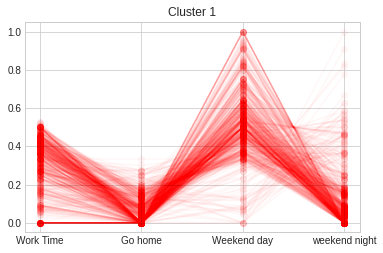

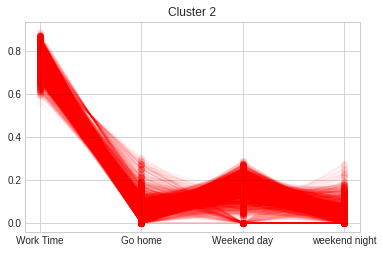

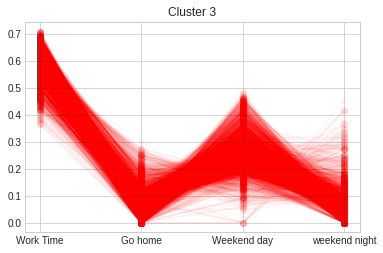

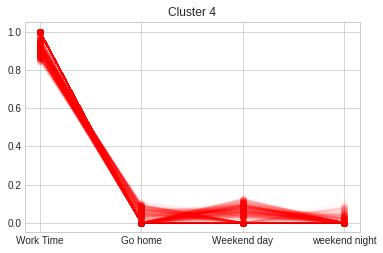

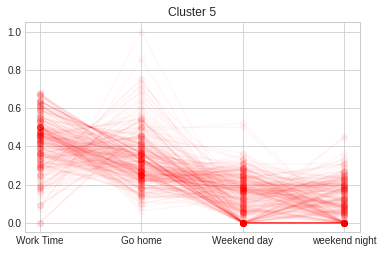

In [ ]:
from google.colab import files

plt.style.use('seaborn-whitegrid')

k = 5

data = pd.DataFrame.from_dict(cell_hehe)

from sklearn.cluster import AgglomerativeClustering #导入sklearn的层次聚类函数
model = AgglomerativeClustering(n_clusters = k, affinity='euclidean', linkage = 'ward')
model.fit(cell_hehe) #训练模型
#详细输出原始数据及其类别

r = pd.concat([data, pd.Series(model.labels_, index = data.index), pd.Series(names, index = data.index)], axis = 1) #详细输出每个样本对应的类别
r.columns = list(data.columns) + ['cluster', 'name'] #重命名表头

r.to_csv('123.csv', encoding='utf-8')
#files.download("123.csv") 

import matplotlib.pyplot as plt

#plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

style = ['ro-', 'go-', 'bo-', 'bo-']

xlabels = [u'Work Time', u'Go home', u'Weekend day', u'weekend night', u'total']

#pic_output = '../tmp/type_' #聚类图文件名前缀
for i in range(k): #逐一作图，作出不同样式
  plt.figure()
  tmp = r[r['cluster'] == i].iloc[:,:4] #提取每一类
  for j in range(len(tmp)):

    plt.plot(range(1, 5), tmp.iloc[j], 'ro-', alpha=0.03)
    plt.xticks(range(1, 5), xlabels, rotation = 0) #坐标标签
    plt.title(u'Cluster %s' %(i+1)) #我们计数习惯从1开始
    plt.subplots_adjust(bottom=0.15) #调整底部

#plt.savefig(u'%s%s.png' %(pic_output, i+1)) #保存图片

In [ ]:
cluster_dict = dict()

for index, row in r.iterrows():
    cluster = row['cluster']
    name = row['name']
    cluster_dict[name] = cluster


In [ ]:
path_to_file = '/content/drive/My Drive/LDA Recommendation/selected.csv'

f = open(path_to_file, encoding='gb18030', errors='ignore')

counter = 0

person_semantic_traj = dict()

for line in f: 
  counter += 1
  if counter > 1:

    line = line.replace('"','',100)
    meta = line.split(',')
    person = meta[0]  
    month = meta[2]
    hour = int(meta[10])
    day = int(meta[3]) - 2

    cell_lac = meta[9]
    cell_ci = meta[8]
    cell_str = cell_lac + '|' + cell_ci

    semantic = -1
    if cell_str in cluster_dict:
      semantic = cluster_dict[cell_str]
    
    if person in person_semantic_traj:
      step = dict()
      step['day'] = day
      step['hour'] = hour
      step['semantic'] = semantic
      #person_semantic_traj[person].append(step)
      person_semantic_traj[person].append([day, hour, semantic])
    else:
      person_semantic_traj[person] = []
      step = dict()
      step['day'] = day
      step['hour'] = hour
      step['semantic'] = semantic
      #person_semantic_traj[person].append(step)
      person_semantic_traj[person].append([day, hour, semantic])
    
fo = open("hehe.json", "w")

info_json = json.dumps(cluster_dict, cls=MyEncoder)

fo.write(info_json)
fo.close()
files.download('hehe.json')

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

seq_length = []

for key in persons_sequence:
  if len(persons_sequence[key]) < 151:
    seq_length.append(len(persons_sequence[key]))

counter = np.array(seq_length)

fig = plt.figure()
#fig.tight_layout()
ax = fig.add_subplot(111)

ax.hist(counter, bins=50)

plt.title("The Histogram of User Base Station Sequence Length", size=10) 

xlabel = plt.xlabel("Length of User's Base Station Sequence", size=9)
ylabel = plt.ylabel('Frequency', size=9)
xlabel.set_fontname('sans-serif')
ylabel.set_fontname('sans-serif')

plt.grid(alpha = 0.2)

ax.set_aspect(aspect=0.025)
                     
plt.savefig('abc.png', dpi=600)



In [ ]:
files.download("abc.png") 

In [ ]:
import json

OD_counter = dict()




for person in persons_sequence:
  cell_traj = persons_sequence[person]
  for i in range(len(cell_traj) - 1):
    prev = cell_traj[i]['cell']

    hour = cell_traj[i]['hour']
    day = cell_traj[i]['day']

    nex = cell_traj[i + 1]['cell']

    od = prev + '-' + nex
    if od in OD_counter:
      if hour in OD_counter[od]['hours']:
        OD_counter[od]['hours'][hour] += 1
      else:
        OD_counter[od]['hours'][hour] = 1

      if day in OD_counter[od]['days']:
        OD_counter[od]['days'][day] += 1
      else:
        OD_counter[od]['days'][day] = 1 

    else:
      OD_counter[od] = dict()
      OD_counter[od]['hours'] = dict()
      OD_counter[od]['days'] = dict()
      OD_counter[od]['hours'][hour] = 1
      OD_counter[od]['days'][day] = 1

'''
cell_neibor = dict()

for source in OD_counter:
  od_list = []
  for target in OD_counter[source]:
    od_list.append([target, OD_counter[source][target]])
  od_list = sorted(od_list, reverse=True, key=lambda x: x[1])[0:10]
  cell_neibor[source] = od_list
'''

fo = open("123.json", "w")

info_json = json.dumps(OD_counter, indent=4, cls=MyEncoder)

fo.write(info_json)
fo.close()
files.download('123.json')

# LDA topic modelling